In [47]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

In [48]:
# %cd /content/drive/MyDrive/Colab Notebooks/

In [49]:
import json
import pandas as pd
import random
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import sys
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import datetime as dt

In [50]:
def read_file(filepath):
    data = []
    with open(filepath, 'r', errors='replace') as file:
        for line in file:
            try:
                json_obj = json.loads(line)
                data.append(json_obj)
            except json.JSONDecodeError:
                pass
    return data


In [51]:
review_data = pd.DataFrame(read_file('C:/Users/yun13369/Downloads/540/yelp_dataset/yelp_academic_dataset_review.json'))
business_data = pd.DataFrame(read_file('C:/Users/yun13369/Downloads/540/yelp_dataset/yelp_academic_dataset_business.json'))

In [52]:
# read the labeld data
label_df=pd.read_csv('C:/Users/yun13369/Downloads/540/df_test_labeled.csv')

In [53]:
label_df.head()

,review_id,text,food_quality,environment,service,convenience,cost_effectiveness
0,ZRRSVXNw3jR66lY_Iz9DDQ,Just left this restaurant......BEWARE....order...,-1,0,-1,0,0
1,9nGyZKtYxkR6zi6laHtEdg,Updating my previous review of this location.....,1,0,-1,0,0
2,urPoX4vS6p5a7yDrMkGIeQ,Pretty outdoor mall right in the heart of Stat...,0,0,0,0,0
3,0IaehZ_ujUHyfAoKul8-aw,"Yeah, I was not impressed by this place at all...",0,1,1,0,0
4,m-23Loxm1O0Vd5HLHs7i3g,Some of the best pizza we've had. Awesome ing...,1,0,0,0,0


In [54]:
# labeled 1000000 data records
label_df.shape

(1000000, 7)

In [55]:
df_full = review_data.join(business_data.set_index('business_id'), on='business_id', rsuffix='_business')
filtered_df = df_full[df_full['categories'].str.contains("Restaurant", na=False)]
labeled_id=pd.read_excel('C:/Users/yun13369/Downloads/540/yelp_dataset/labeled_review_id.xlsx')
filtered_df = filtered_df[~filtered_df['review_id'].isin(labeled_id['review_id'])]

# join filtered_df with label data
filtered_df=pd.merge(filtered_df,label_df,left_on='review_id',right_on='review_id',how='left')

filtered_df = filtered_df[['date','stars','useful', 'funny', 'cool', 'text_x','food_quality','environment','service','convenience','cost_effectiveness']]
filtered_df = filtered_df.rename(columns={'text_x':'text'})

sample_size = 1000000
filtered_df = filtered_df.sample(n=sample_size, random_state=42)
filtered_df = filtered_df.dropna()

In [56]:
# delete this part
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 987565 entries, 3611164 to 3011421
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   date                987565 non-null  object 
 1   stars               987565 non-null  float64
 2   useful              987565 non-null  int64  
 3   funny               987565 non-null  int64  
 4   cool                987565 non-null  int64  
 5   text                987565 non-null  object 
 6   food_quality        987565 non-null  float64
 7   environment         987565 non-null  float64
 8   service             987565 non-null  float64
 9   convenience         987565 non-null  float64
 10  cost_effectiveness  987565 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 90.4+ MB


In [57]:
filtered_df.head(20)

,date,stars,useful,funny,cool,text,food_quality,environment,service,convenience,cost_effectiveness
3611164,2017-02-20 22:03:33,1.0,0,0,0,Just left this restaurant......BEWARE....order...,-1.0,0.0,-1.0,0.0,0.0
2181081,2018-02-14 18:51:51,1.0,1,0,0,Updating my previous review of this location.....,1.0,0.0,-1.0,0.0,0.0
954153,2015-11-30 23:56:07,4.0,1,1,1,Pretty outdoor mall right in the heart of Stat...,0.0,0.0,0.0,0.0,0.0
3769474,2009-05-15 00:06:58,2.0,2,1,2,"Yeah, I was not impressed by this place at all...",0.0,1.0,1.0,0.0,0.0
2085325,2011-05-17 01:50:34,5.0,1,0,0,Some of the best pizza we've had. Awesome ing...,1.0,0.0,0.0,0.0,0.0
770304,2019-03-02 19:46:10,1.0,0,0,0,literally a joke in regards to service. the pi...,-1.0,0.0,-1.0,0.0,0.0
3817864,2017-05-15 15:43:06,3.0,0,0,0,Spent a few hours here to wrap up our Mother's...,-1.0,0.0,-1.0,0.0,0.0
4240803,2015-07-04 03:22:19,4.0,4,1,2,"For my Combo Plate, I chose the Chicken Katsu ...",1.0,0.0,1.0,0.0,0.0
707924,2009-02-17 19:50:44,3.0,4,3,3,It was good. AND SO MUCH FUN!\nI took the bf f...,-1.0,0.0,0.0,0.0,0.0
4423096,2016-03-15 17:48:16,2.0,0,0,0,"Pretty fair to say, based on past reviews that...",1.0,0.0,1.0,0.0,0.0


In [58]:
translator = str.maketrans('', '', string.punctuation)

def preprocess_text(text):

    text = text.translate(translator)
    text = text.lower()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]

    return ' '.join(words)

In [59]:
filtered_df['cleaned_text'] = filtered_df['text'].apply(preprocess_text)

In [60]:
unwanted_words = ['food', 'good', 'great', 'us']

filtered_df['cleaned_text'] = filtered_df['cleaned_text'].str.replace('food ', '')
filtered_df['cleaned_text'] = filtered_df['cleaned_text'].str.replace('good ', '')
filtered_df['cleaned_text'] = filtered_df['cleaned_text'].str.replace('great ', '')
filtered_df['cleaned_text'] = filtered_df['cleaned_text'].str.replace('place ', '')
filtered_df['cleaned_text'] = filtered_df['cleaned_text'].str.replace('order ', '')
filtered_df['cleaned_text'] = filtered_df['cleaned_text'].str.replace(' us ', '')
filtered_df['cleaned_text'] = filtered_df['cleaned_text'].str.strip()

In [61]:
filtered_df

,date,stars,useful,funny,cool,text,food_quality,environment,service,convenience,cost_effectiveness,cleaned_text
3611164,2017-02-20 22:03:33,1.0,0,0,0,Just left this restaurant......BEWARE....order...,-1.0,0.0,-1.0,0.0,0.0,left restaurantbewareordered steaksfilet lobst...
2181081,2018-02-14 18:51:51,1.0,1,0,0,Updating my previous review of this location.....,1.0,0.0,-1.0,0.0,0.0,updating previous review location im really di...
954153,2015-11-30 23:56:07,4.0,1,1,1,Pretty outdoor mall right in the heart of Stat...,0.0,0.0,0.0,0.0,0.0,pretty outdoor mall right heart state street s...
3769474,2009-05-15 00:06:58,2.0,2,1,2,"Yeah, I was not impressed by this place at all...",0.0,1.0,1.0,0.0,0.0,yeah impressed inside dark sparsely decorated ...
2085325,2011-05-17 01:50:34,5.0,1,0,0,Some of the best pizza we've had. Awesome ing...,1.0,0.0,0.0,0.0,0.0,best pizza weve awesome ingredients nice crust...
...,...,...,...,...,...,...,...,...,...,...,...,...
3167119,2020-10-19 17:43:41,2.0,0,0,0,They skimp on filling your bowl up unlike othe...,1.0,0.0,0.0,0.0,0.0,skimp filling bowl unlike chipotles area also ...
2121247,2011-08-24 16:37:07,5.0,0,0,0,This was a great place. The servers were great...,1.0,0.0,1.0,0.0,0.0,servers friendly started blueberry salad fanta...
395933,2021-03-25 17:42:38,5.0,2,1,1,AMAZING food and ambiance. Would love to go ag...,1.0,1.0,1.0,0.0,0.0,amazing ambiance would love go highly suggest ...
4504828,2019-08-09 01:58:16,2.0,0,0,0,Went in for a late dinner and some drinks. Foo...,-1.0,0.0,-1.0,0.0,-1.0,went late dinner drinks mediocre drinks taste ...


In [62]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_df['cleaned_text'])

In [63]:
tfidf_matrix

<987565x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 38138577 stored elements in Compressed Sparse Row format>

In [64]:
numeric_columns = ['stars', 'useful', 'funny', 'cool']
numeric_data = filtered_df[numeric_columns].values

In [65]:
combined_matrix = hstack([tfidf_matrix, numeric_data])

scaler = StandardScaler(with_mean=False, with_std=True)
combined_matrix = scaler.fit_transform(combined_matrix)

In [66]:
svd = TruncatedSVD(n_components=100)
svd.fit(combined_matrix)
svd_data = svd.transform(combined_matrix)

In [67]:
feature_names = tfidf_vectorizer.get_feature_names_out()

In [68]:
def plot_top_words_per_cluster_wordcloud(cluster_words):
    num_clusters = len(cluster_words)

    fig, axs = plt.subplots(1, num_clusters, figsize=(3 * num_clusters, 2))
    fig.suptitle('Top Words for Each Cluster (WordCloud)', fontsize=16)

    for cluster, top_words in cluster_words.items():
        ax = axs[cluster] if num_clusters > 1 else axs  # Handle single-cluster case

        # Create a WordCloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(top_words))

        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f'Cluster {cluster}', fontsize=14)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



In [69]:
def get_top_words_per_cluster(tfidf_matrix, cluster_labels, feature_names, n_words=10):

    cluster_words = {}

    for cluster in range(max(cluster_labels) + 1):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_tfidf = tfidf_matrix[cluster_indices].sum(axis=0)
        top_indices = cluster_tfidf.argsort()[0, ::-1][:n_words]
        top_words = [str(feature_names[i]) for i in top_indices]
        cluster_words[cluster] = top_words

    return cluster_words

Cluster 2 start
Cluster 2 finished


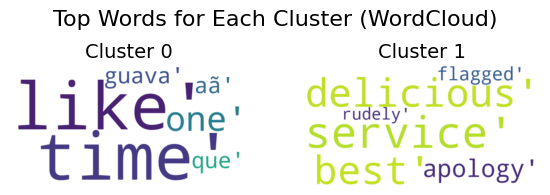

Cluster 3 start
Cluster 3 finished


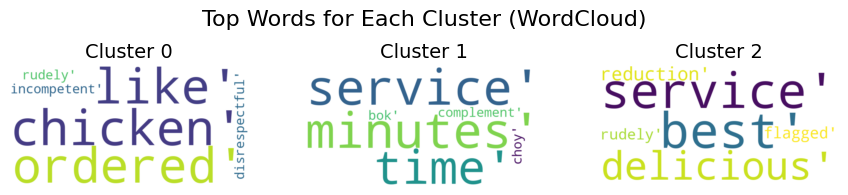

Cluster 4 start
Cluster 4 finished


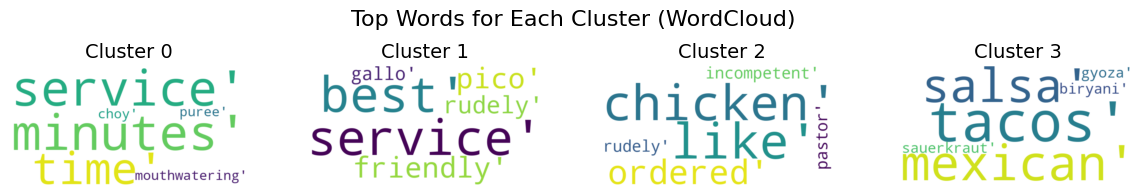

Cluster 5 start
Cluster 5 finished


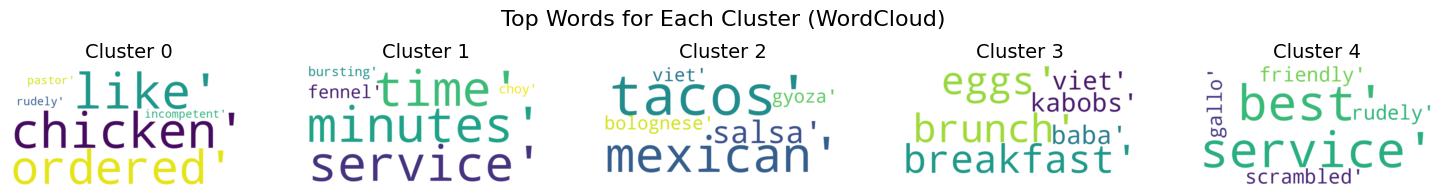

Cluster 6 start
Cluster 6 finished


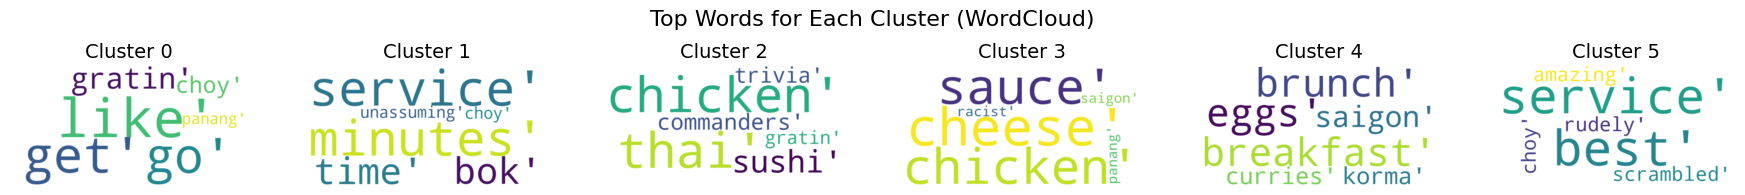

Cluster 7 start
Cluster 7 finished


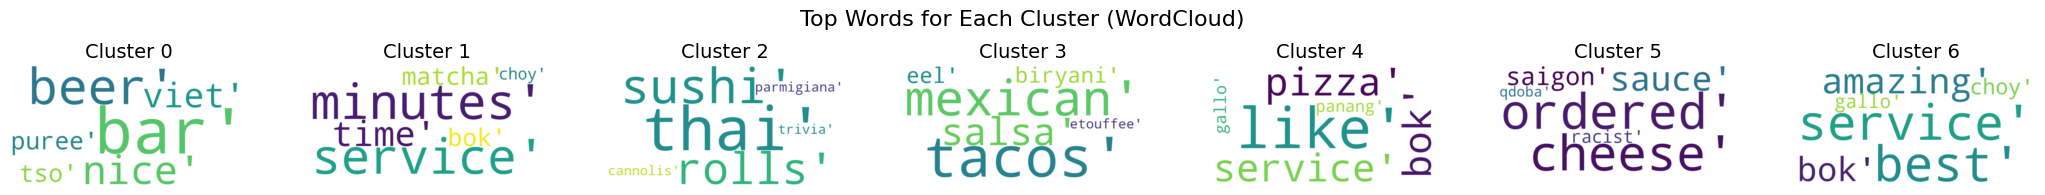

Cluster 8 start
Cluster 8 finished


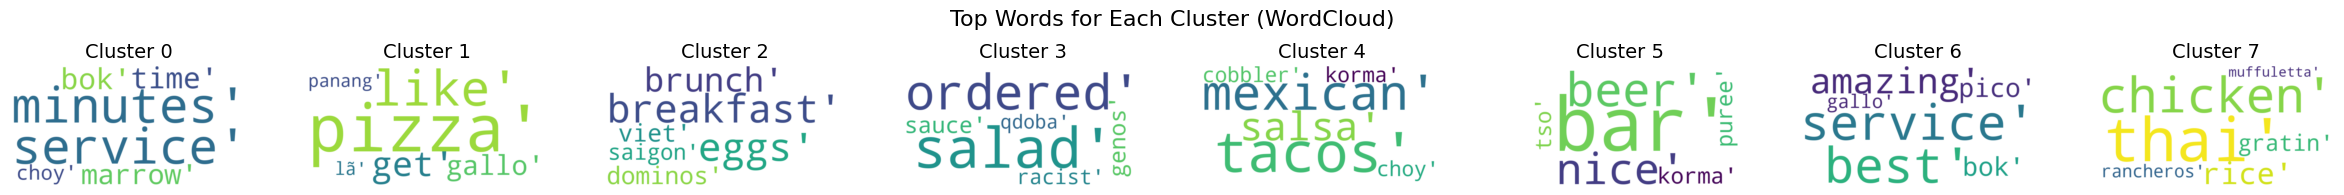

Cluster 9 start
Cluster 9 finished


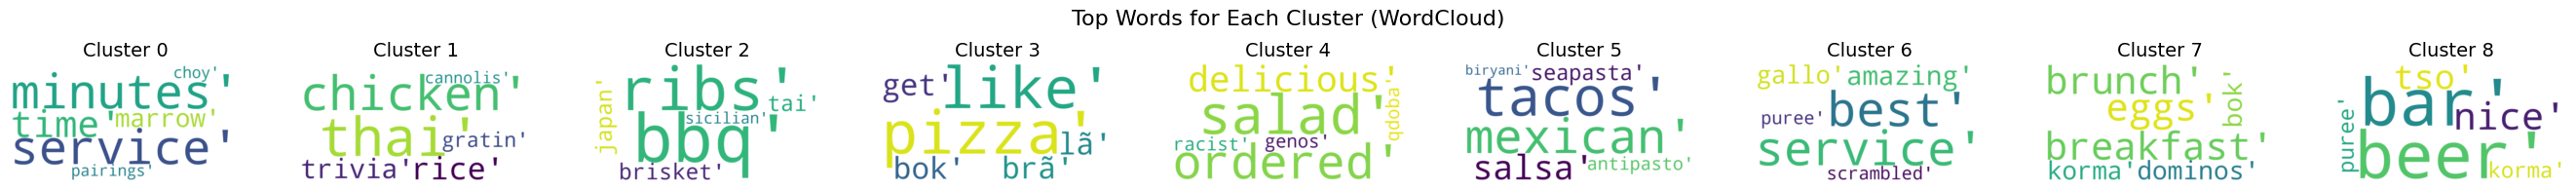

In [70]:
k_values = list(range(2, 10))
silhouette_scores = []

for i, k in enumerate(k_values):
    print(f'Cluster {k} start')

    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10, max_iter=500)
    cluster_labels = kmeans.fit_predict(svd_data)

    print(f'Cluster {k} finished')

    cluster_words=get_top_words_per_cluster(tfidf_matrix, cluster_labels, feature_names)
    plot_top_words_per_cluster_wordcloud(cluster_words)

In [76]:
# time series plot
def get_time_series_plot(k,df):
# k is the number of optimized clusters
  df_cluster=df.copy()
  kmeans = KMeans(n_clusters=k, random_state=0, n_init=10, max_iter=500)
  cluster_labels = kmeans.fit_predict(svd_data)
  df_cluster['cluster']=cluster_labels
  df_cluster['date'] = pd.to_datetime(df_cluster['date'])
  labels=['food_quality','environment','service','convenience','cost_effectiveness']

  # Create a matrix of subplots
  fig, axes = plt.subplots(k, len(labels), figsize=(15, 15), sharex=True, sharey=True)

  for c in range(k):
      # for each cluster, plot the trend for five labels
      # NEED PREPROCESSING OF TIME HERE,use month
      df_cluster['monthly_time']=df_cluster['date'].dt.to_period('M')
      df_cluster['quater_time']=df_cluster['date'].dt.to_period('Q')
      df_cluster=df_cluster.sort_values(by='quater_time')

      for i, label in enumerate(labels):
          # Create a pivot table to get counts for each category and quarter
          pivot_table = df_cluster[df_cluster['cluster'] == c].pivot_table(index='quater_time', columns=label, aggfunc='size', fill_value=0)
          # Calculate percentage distribution
          percentage_distribution = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

          # Plot on the corresponding subplot as stacked bar
          bottom = 0
          for col in percentage_distribution.columns:
              axes[c, i].bar(percentage_distribution.index.astype(str), percentage_distribution[col], label=col, bottom=bottom)
              bottom += percentage_distribution[col]

          axes[c, i].set_title('Cluster ' + str(c + 1) + ': ' + label)
          axes[c, i].legend()

          # Customize x-axis labels
          axes[c, i].tick_params(axis='x', rotation=45, labelsize=7)  # Rotate labels by 45 degrees, set fontsize

          # Set x-axis ticks at the bottom of each plot
          axes[c, i].xaxis.set_ticks_position('bottom')

          # Set x-axis ticks to unique quarter values
          unique_quarters = df_cluster['quater_time'].unique()
          axes[c, i].set_xticks(range(len(unique_quarters)))
          axes[c, i].set_xticklabels(unique_quarters.astype(str))

          # Adjust x-axis ticks based on desired frequency (e.g., every 2 quarters)
          ticks = axes[c, i].get_xticks()
          new_ticks = [ticks[i] for i in range(0, len(ticks), 5)]
          axes[c, i].set_xticks(new_ticks)

  # Set common labels
  for ax in axes.flat:
      ax.set(xlabel='Time', ylabel='Percentage')

  # Adjust layout
  plt.tight_layout()
  plt.show()

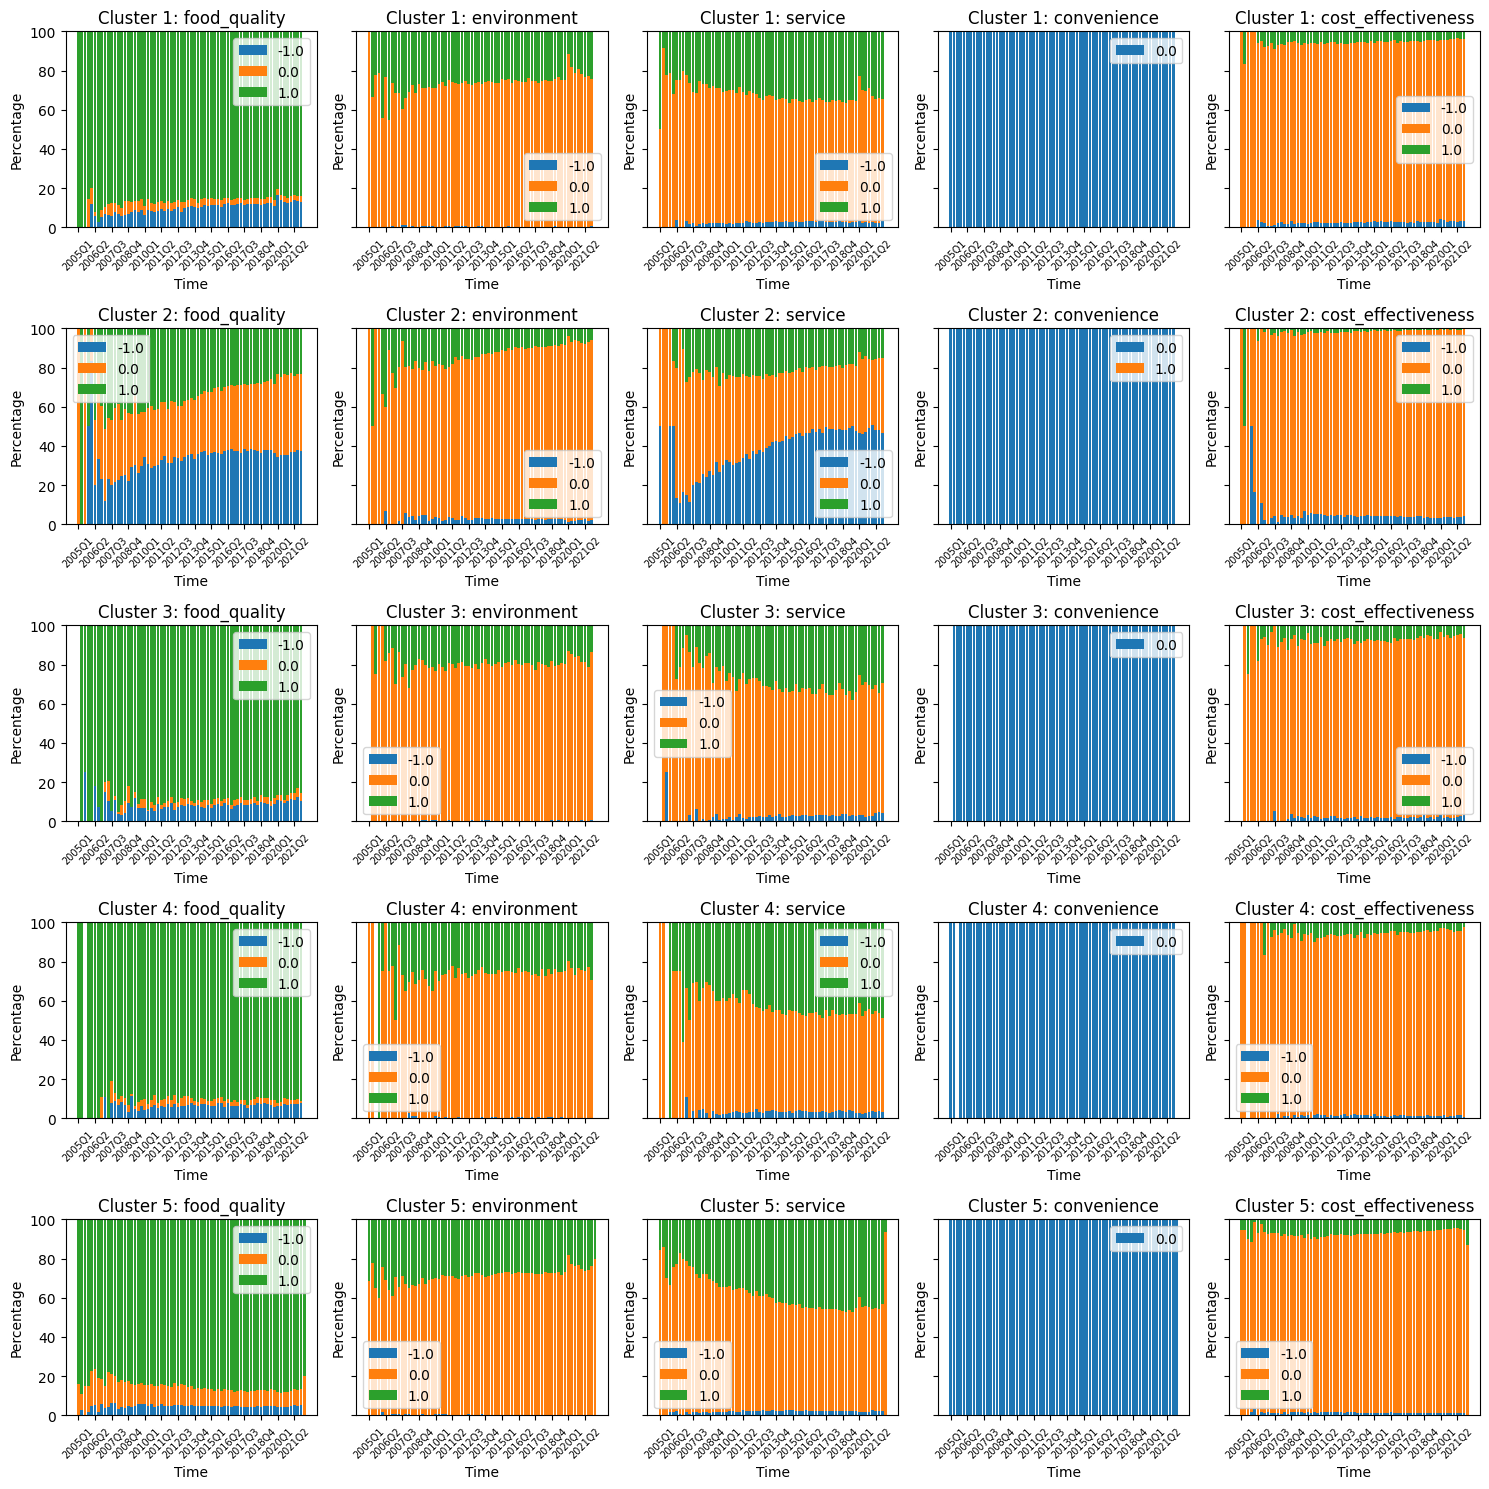

In [72]:
get_time_series_plot(5,filtered_df)